In [0]:
%matplotlib inline


# Faces recognition example using eigenfaces and SVMs


The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)


Expected results for the top 5 most represented people in the dataset:

================== ============ ======= ========== =======
                   precision    recall  f1-score   support
================== ============ ======= ========== =======
     Ariel Sharon       0.67      0.92      0.77        13
     Colin Powell       0.75      0.78      0.76        60
  Donald Rumsfeld       0.78      0.67      0.72        27
    George W Bush       0.86      0.86      0.86       146
Gerhard Schroeder       0.76      0.76      0.76        25
      Hugo Chavez       0.67      0.67      0.67        15
       Tony Blair       0.81      0.69      0.75        36

      avg / total       0.80      0.80      0.80       322
================== ============ ======= ========== =======




2020-03-09 03:35:05,955 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012


Automatically created module for IPython interactive environment


2020-03-09 03:35:07,418 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2020-03-09 03:35:08,695 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2020-03-09 03:35:10,266 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])
(1288, 1850)
(1288, 50, 37)
(1288,)
['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


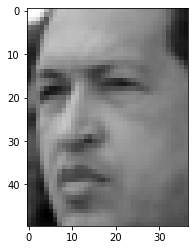

In [0]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
print(lfw_people.keys())
print(lfw_people.data.shape)
print(lfw_people.images.shape)
print(lfw_people.target.shape)
print(lfw_people.target_names)
plt.imshow(lfw_people.images[0], cmap=plt.cm.gray)

In [0]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
print("n_samples, height and width of data = ", n_samples, h, w)
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
print("Target names", target_names)
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


n_samples, height and width of data =  1288 50 37
Target names ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [0]:


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
print("Shape of X_train", X_train.shape)
print("Shape of X_test", X_test.shape)
print("Shape of y_train", y_train.shape)
print("Shape of y_test", y_test.shape)

Shape of X_train (966, 1850)
Shape of X_test (322, 1850)
Shape of y_train (966,)
Shape of y_test (322,)


In [0]:
# #############################################################################
# Compute a PCA on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

print("Components of PCA", pca.components_.shape)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Shape after converting to original face shape", eigenfaces.shape)
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("X_train_pca shape", X_train_pca.shape)
print("X_test pca shape", X_test_pca.shape)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.195s
Components of PCA (150, 1850)
Shape after converting to original face shape (150, 50, 37)
Projecting the input data on the eigenfaces orthonormal basis
X_train_pca shape (966, 150)
X_test pca shape (322, 150)
done in 0.026s


In [0]:
# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5, iid=False)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))




Fitting the classifier to the training set


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


done in 45.545s
Best estimator found by grid search:
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.005,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.075s
                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.46      0.60        13
     Colin Powell       0.80      0.87      0.83        60
  Donald Rumsfeld       0.85      0.63      0.72        27
    George W Bush       0.84      0.98      0.90       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       0.89      0.53      0.67        15
       Tony Blair       0.97      0.78      0.86        36

         accuracy                           0.85       322
        macro avg       0.88      0.72      0.78       322
     weighted avg       0.86      0.85   

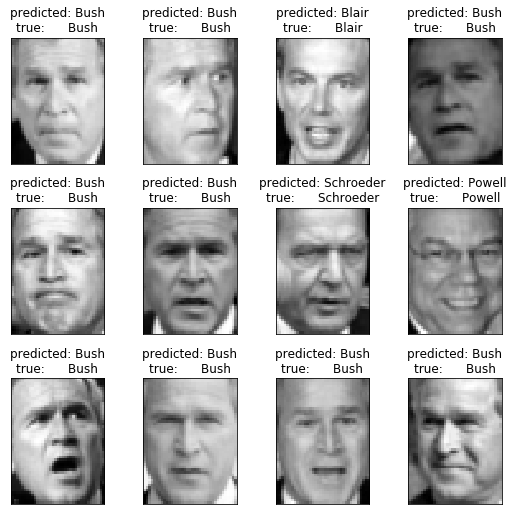

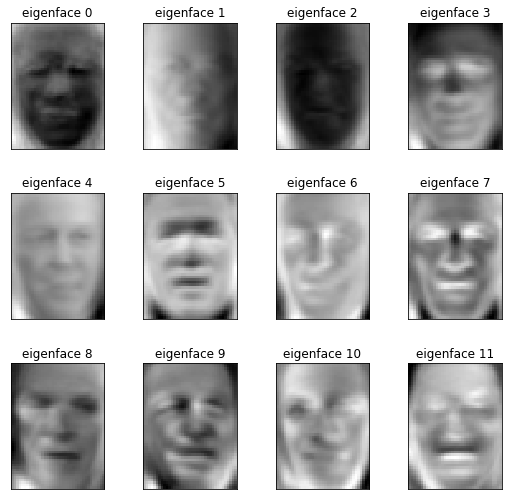

In [0]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

(427, 640, 3)


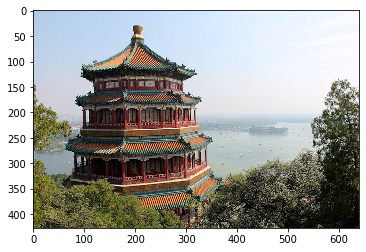

In [0]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_image
X = load_sample_image('china.jpg')
plt.imshow(X)
h, w, _ = X.shape
print(X.shape)

In [0]:
from sklearn.mixture import GaussianMixture
X = X.reshape(-1,3)
print("X shape = ", X.shape)
gmm = GaussianMixture(covariance_type='full', n_components=5)
gmm.fit(X)
labels = gmm.predict(X)
print("Clusters shape = ", labels.shape)

X shape =  (273280, 3)
Clusters shape =  (273280,)


Clusters shape =  (427, 640)


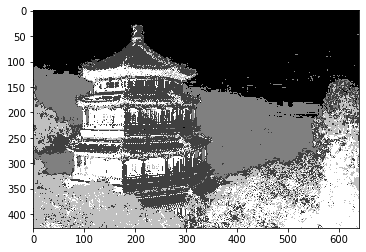

In [0]:
clusters = labels.reshape(-1, w)
print("Clusters shape = ", clusters.shape)
plt.imshow(clusters, cmap='gray')